# How to create a circuit with mid-circuit measurements
**Creating and running a circuit with mid-circuit measurements with Fire Opal**

Mid-circuit measurement is a technique for measuring qubits at intermediate points in a circuit, which can provide new capabilities and greater efficiencies for certain quantum algorithms. For example, in error correction schemes, measured ancilla qubits inform which recovery operations to apply. Fire Opal optimizes circuits that use end-of-circuit measurements, mid-circuit measurements, or any combination of the two, ensuring errors are suppressed. It also supports [multiple classical registers](https://docs.q-ctrl.com/fire-opal/execute/configure-circuits/how-to-create-a-circuit-with-multiple-registers) on supported backends.

In this guide, you will learn how to:
1. Use a single classical register for sequential measurements
2. Use different classical registers for sequential measurements
3. Reuse the same classical register for mid-circuit and end-of-circuit measurements

### 1. Set up your environment
First, import the necessary packages. In this example, Qiskit is used to create the circuit, but you can use any preferred programming framework, export the circuit to QASM, and pass it to `fireopal.execute`.

In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, qasm3
import json
import fireopal as fo

In [ ]:
# Set credentials
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

credentials = fo.credentials.make_credentials_for_ibm_cloud(
    token=token, instance=instance
)

Q-CTRL authentication successful!


#### 2.1 Using a single classical register for sequential measurements
In this circuit, a single 4-bit classical register is used to record measurement outcomes at two points during execution. This example demonstrates how mid-circuit and end-of-circuit measurements can be stored in different bit positions of the same classical register.

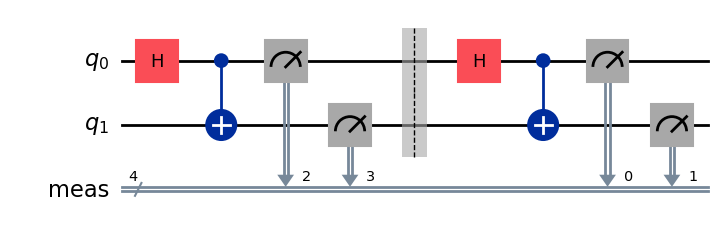

In [3]:
cr = ClassicalRegister(4, name="meas")
qr = QuantumRegister(2, name="q")
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr[2:])

qc.barrier(qr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr[:2])

qc.draw("mpl")

Choose a backend to run the circuit. Run `fo.show_supported_devices(credentials)` to get a list of suppported backend names.

In [4]:
fo.show_supported_devices(credentials)

{'supported_devices': ['ibm_kingston',
  'ibm_marrakesh',
  'ibm_fez',
  'ibm_pittsburgh',
  'ibm_torino',
  'ibm_brisbane']}

In [ ]:
# Replace "your_desired_backend" with the name of the device you wish to use.
backend_name = "your_desired_backend"

In [6]:
shot_count = 1024

fire_opal_job = fo.execute(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

Inspect the results using the Fire Opal `result()` method.

In [10]:
fire_opal_results = fire_opal_job.result()["execution_results"][0]
print(json.dumps(fire_opal_results, indent=2))

{
  "meas": {
    "0000": 0.2387751781873123,
    "0001": 0.0014997656097064176,
    "0010": 0.000702130720886286,
    "0011": 0.25576615750454207,
    "0100": 0.0029982030334764855,
    "0101": 0.002506776350397814,
    "0111": 0.0009680081541108427,
    "1001": 0.003507245332868281,
    "1010": 0.0016125637524880539,
    "1100": 0.00018856692346275024,
    "1101": 0.24800474963258376,
    "1110": 0.2402056273034691,
    "1111": 0.0032650274946958453
  }
}


The first half of the circuit creates a Bell pair and measures it into the two leftmost classical bits (bits 2 and 3). Hence, 50% of the time we expect to observe `00` and 50% `11`.

Once the Bell pair is measured, it no longer exists; the measurement projects it onto either `|00>` or `|11>`. If the Bell state is projected onto `|00>`, the second half of the circuit prepares another Bell state and measures it into the two rightmost bits (bits 0 and 1). If the Bell state is projected onto `|11>`, the second half of the circuit prepares a different Bell state (an equal superposition of `|01>` and `|10>`) and measures it, as before, into the two rightmost bits.

Therefore, on an ideal device, the final outcomes are uniformly distributed over the four bitstrings `0000`, `0011`, `1101`, and `1110` (25% each).

#### 2.2 Using different classical registers for sequential measurements
In this second circuit example, two classical registers are used, each capturing the results of one measurement stage. This explicit separation is particularly useful for algorithms with both mid-circuit and end-of-circuit measurements.

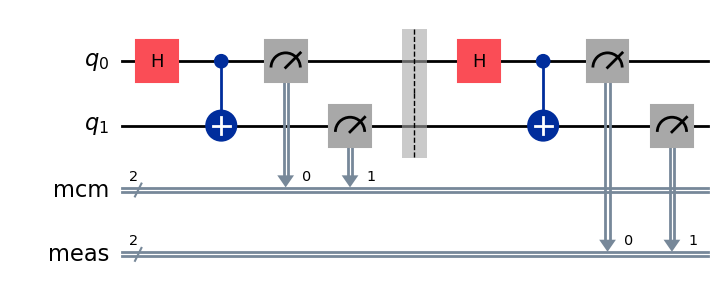

In [11]:
cr1 = ClassicalRegister(2, name="mcm")
cr2 = ClassicalRegister(2, name="meas")
qr = QuantumRegister(2, name="q")
qc = QuantumCircuit(qr, cr1, cr2)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr1)  # first stage results in "mcm"

qc.barrier(qr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr2)  # second stage results in "meas"

qc.draw("mpl")

In [12]:
fire_opal_job = fo.execute(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

In [13]:
fire_opal_results = fire_opal_job.result()["execution_results"][0]
print(json.dumps(fire_opal_results, indent=2))

{
  "mcm": {
    "00": 0.4981900505527199,
    "01": 0.002086906611238775,
    "10": 0.005063140672958655,
    "11": 0.49465990216308275
  },
  "meas": {
    "00": 0.2453795575492129,
    "01": 0.24997371669992552,
    "10": 0.2459762486225556,
    "11": 0.25867047712830604
  }
}


Here, each classical register records the results separately.

The first register records the Bell pair prepared in the first half of the circuit. In the second half of the circuit, we prepare, with 50% probability, an equal superposition of `|00>` and `|11>`, and, with 50% probability, an equal superposition of `|01>` and `|10>`, so each of the four bitstrings is equally likely.

Notice that in this case we lose information about the correlation between the first-stage and second-stage outcomes if we look at each results dictionary independently (marginals). For example, the second dictionary shows that the probability of observing `00` is 25%, but it does not reveal that this outcome occurs only when the two bits in the first dictionary are `00`.

To retain correlation information across measurements, measure into the same classical register or compute joint counts across registers. If correlations are not required, storing results in separate registers is fine.

#### 2.3 Reuse the same classical register for mid-circuit and end-of-circuit measurements
In this last circuit, a single 2-bit classical register is reused for both a mid-circuit measurement (MCM) and the end-of-circuit measurement. When the same classical bits are reused, the later measurement overwrites the earlier values; if different bit positions are used, earlier results are preserved. Take care not to unintentionally reuse the same classical bits, as this will overwrite earlier measurements and lose information.

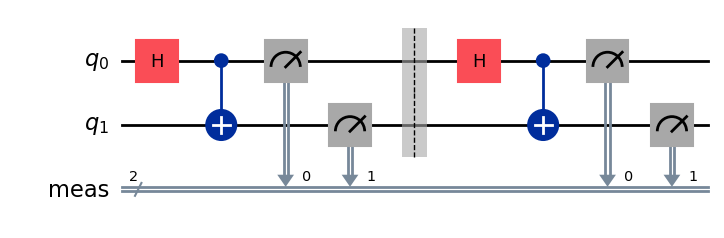

In [14]:
cr = ClassicalRegister(2, name="meas")
qr = QuantumRegister(2, name="q")
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr)

qc.barrier(qr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr)

qc.draw("mpl")

In [19]:
fire_opal_job = fo.execute(
    circuits=[qasm3.dumps(qc)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

In [20]:
fire_opal_results = fire_opal_job.result()["execution_results"][0]
print(json.dumps(fire_opal_results, indent=2))

{
  "meas": {
    "00": 0.2419746156975078,
    "01": 0.2615188744068352,
    "10": 0.23044099122102318,
    "11": 0.2660655186746339
  }
}


Notice that the results above are produced by the later set of measurements - the information from the earlier set of measurements has been overwritten.

In summary, the above examples demonstrate how mid-circuit measurements can be incorporated into quantum circuits, with Fire Opal providing the error suppression needed to explore practical quantum applications.

The following package versions were used to produce this notebook.

In [18]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.9  |
| matplotlib            | 3.10.1  |
| networkx              | 3.5     |
| numpy                 | 2.3.2   |
| qiskit                | 1.4.2   |
| sympy                 | 1.14.0  |
| fire-opal             | 9.0.2   |
| qctrl-workflow-client | 6.0.0   |
